## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Мария Мансурова, аналитик-разработчик в команде Яндекс.Метрики. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9. (демо)
## <center> Анализ временных рядов
    
**Заполните пропущенный код и ответьте на вопросы в [онлайн-форме](https://docs.google.com/forms/d/1ijk4aFKY5plPiI8z3Mgi3i1Ln94VBY9SSt6xGIdVVFQ/).**

In [ ]:
import os

import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
import matplotlib.pyplot as plt

print(__version__)  # need 1.9.0 or greater

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

4.4.1


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [ ]:
df = pd.read_csv("wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [ ]:
df.shape

(383, 7)

In [ ]:
df.date = pd.to_datetime(df.date)

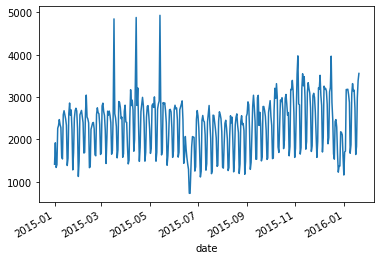

In [ ]:
#plotly_df(df.set_index("date")[["count"]])
df.set_index("date")["count"].plot();

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [ ]:
from fbprophet import Prophet

In [ ]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
train_df = df[:-predictions].copy()

In [ ]:
%%time
## ВАШ КОД для построения модели ##
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 1.04 s, sys: 240 ms, total: 1.28 s
Wall time: 1.21 s


In [ ]:
## ВАШ КОД для оценки качества полученной модели ##
future = m.make_future_dataframe(periods=predictions) #future = df[-predictions:]['ds']
future.tail(3)

,ds
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [ ]:
forecast = m.predict(future)
future.tail(3)

,ds
380,2016-01-18
381,2016-01-19
382,2016-01-20


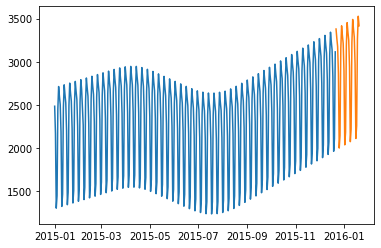

In [ ]:
plt.plot(forecast[:-predictions]['ds'], forecast[:-predictions]['yhat'])
plt.plot(forecast[-predictions:]['ds'], forecast[-predictions:]['yhat']);

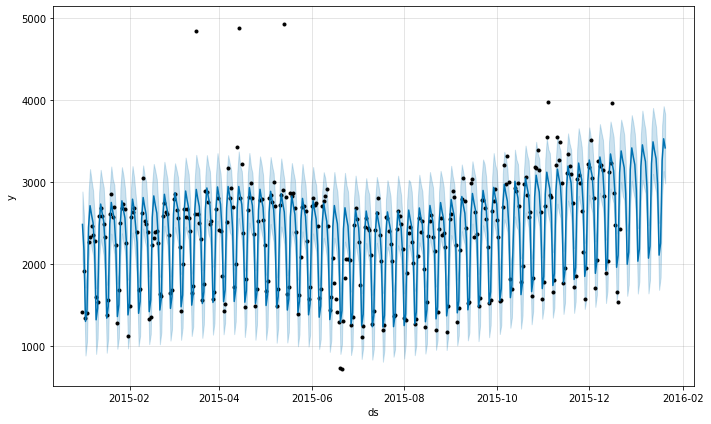

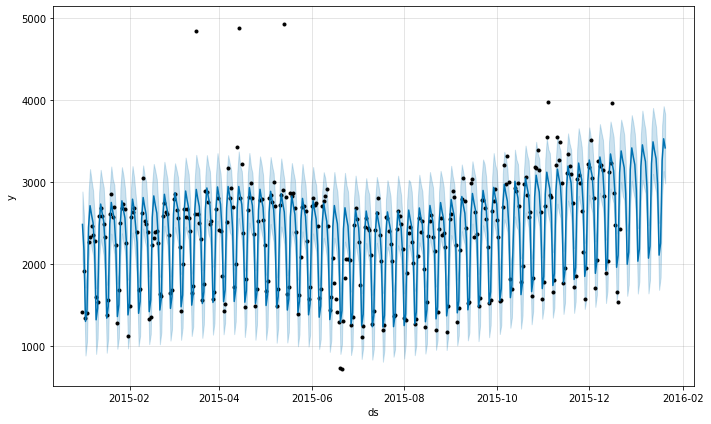

In [ ]:
m.plot(forecast)

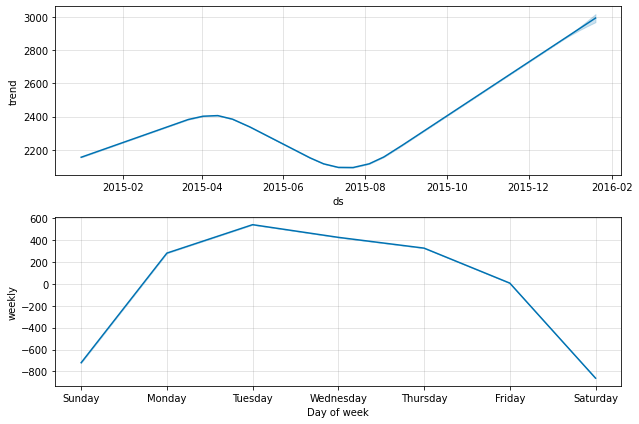

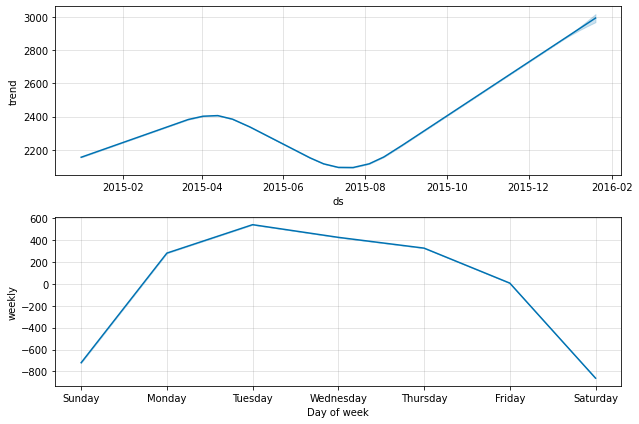

In [ ]:
m.plot_components(forecast)

**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [ ]:
forecast[['ds', 'yhat']].tail(1)

,ds,yhat
382,2016-01-20,3417.399199


**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

In [ ]:
from sklearn.metrics import mean_absolute_error
try:
  from sklearn.metrics import mean_absolute_percentage_error
except:
  print('IDK what is it...')

IDK what is it...


In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])

593.1030432193476

In [ ]:
mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])

34.18114876407993

## Предсказываем с помощью ARIMA

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
# plt.rcParams['figure.figsize'] = (15, 10)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

Критерий Дики-Фуллера: p=0.107392


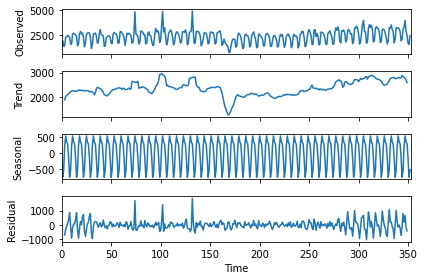

In [ ]:
## ВАШ КОД для проверки стационарности ряда ##
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();

In [ ]:
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
  if not isinstance(y, pd.Series):
    y = pd.Series(y)
  with plt.style.context(style):    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title('Time Series Analysis Plots')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

    plt.tight_layout()
  return 
#tsplot(train_df.set_index("ds")['y'], lags=58)

Критерий Дики-Фуллера: p=0.116981
Оптимальный параметр преобразования Бокса-Кокса: 0.732841


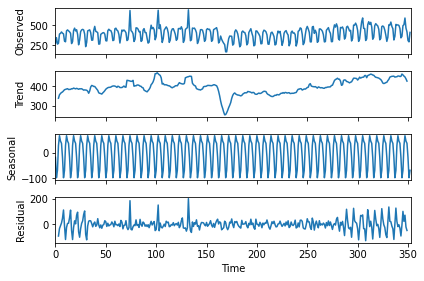

In [ ]:
def invboxcox(y,lmbda):
  # обрабтное преобразование Бокса-Кокса
  if lmbda == 0:
    return(np.exp(y))
  else:
    return(np.exp(np.log(lmbda*y+1)/lmbda))

train_df['y_box'], lmbda = stats.boxcox([1 if x==0 else x for x in train_df['y']]) # прибавляем единицу, так как в исходном ряде есть нули
sm.tsa.seasonal_decompose(train_df['y_box'].values, freq=7).plot()
#tsplot(train_df.set_index("ds")['y_box'], lags=58)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y_box'])[1])
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

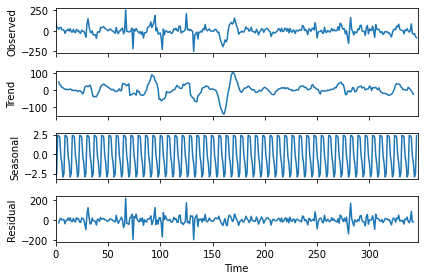

In [ ]:
train_df['y_box_diff'] = train_df['y_box'] - train_df['y_box'].shift(7)
plt.figure(figsize=(15, 10))
sm.tsa.seasonal_decompose(train_df['y_box_diff'][7:].values, freq=7).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y_box_diff'][7:])[1])

Критерий Дики-Фуллера: p=0.000000


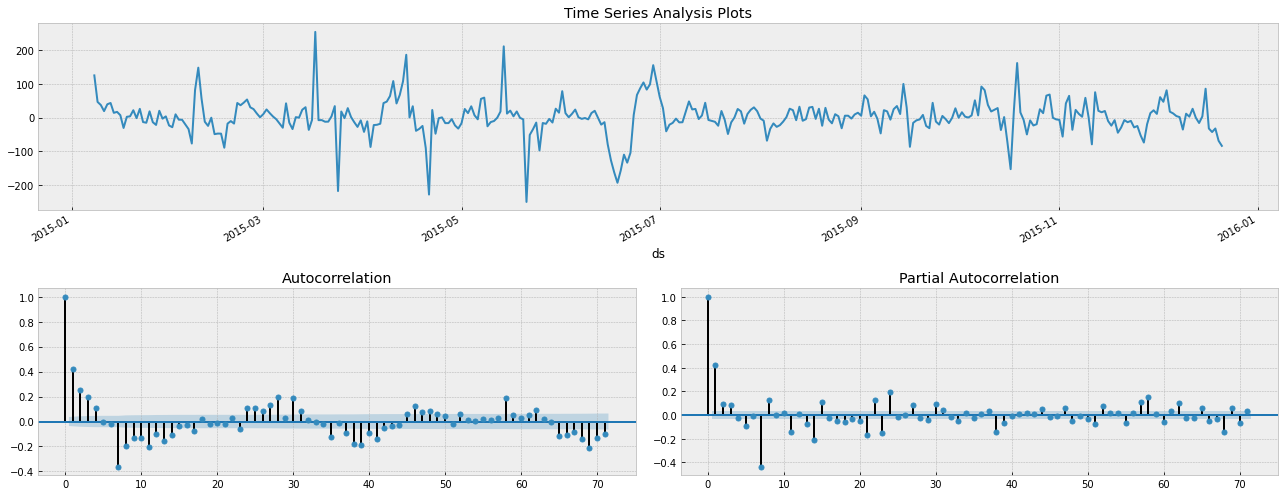

In [ ]:
tsplot(train_df.set_index("ds")['y_box_diff'][7:], lags=71, figsize=(18,7))

Начальные приближения Q=2, q=4, P=4, p=5

In [ ]:
ps = range(0, 6)
d = 0
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 3)

In [ ]:
from itertools import product

parameters = list(product(ps, qs, Ps, Qs))
len(parameters)

450

In [ ]:
%%time
import warnings # очень много предупреждений
warnings.filterwarnings('ignore')
from tqdm import tqdm

results = []
best_aic = float('inf')

# for i, param in enumerate(parameters):
#    if (10*i) % len(parameters) == 0:
#        print('Iterations =', i, '/', len(parameters))
for param in tqdm(parameters):
    #print(param)
    # try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
      model = sm.tsa.statespace.SARIMAX(\
                  train_df['y_box'],\
                  order=(param[0], d, param[1]),\
                  seasonal_order=(param[2], D, param[3], 7),\
              ).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print("wrong parameters:", param)
        continue
    aic = model.aic
    # сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings("default")

100%|██████████| 450/450 [37:37<00:00,  5.02s/it]

CPU times: user 42min 58s, sys: 30min 58s, total: 1h 13min 56s
Wall time: 37min 37s


**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
print(result_table.sort_values(by="aic", ascending=True).head())

       parameters          aic
399  (5, 1, 3, 0)  3553.343443
280  (3, 3, 3, 1)  3553.938679
219  (2, 4, 3, 0)  3554.015344
144  (1, 4, 3, 0)  3554.041686
279  (3, 3, 3, 0)  3554.234192


In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(5, 0, 1)x(3, 1, 0, 7)   Log Likelihood               -1766.672
Date:                           Tue, 11 May 2021   AIC                           3553.343
Time:                                   09:45:56   BIC                           3591.808
Sample:                                        0   HQIC                          3568.660
                                           - 353                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4408      0.054     -8.177      0.000      -0.546      -0.335
ar.L2          0.3976      0.058      6.799

Критерий Дики-Фуллера: p=0.000000
Критерий Стьюдента: p=0.346124


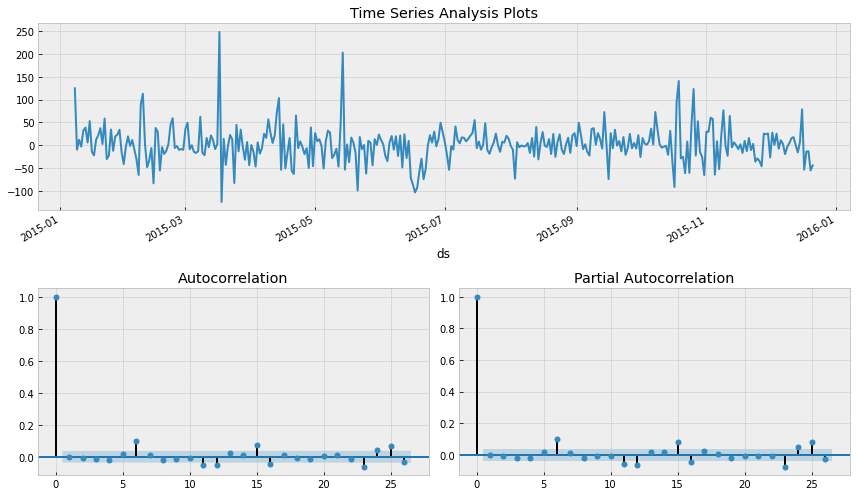

In [ ]:
tsplot(pd.Series(best_model.resid[7:].values.squeeze(), train_df[7:]['ds']).sort_index())
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[7:], 0)[1])

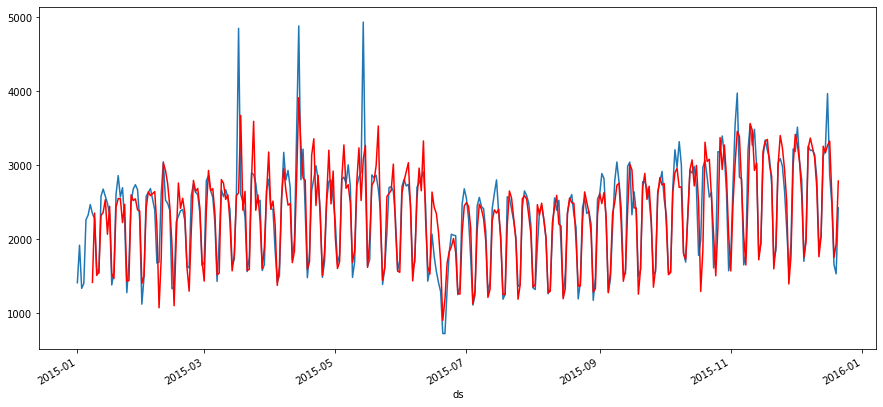

In [ ]:
train_df["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15, 7))
train_df.set_index('ds').sort_index()['y'].plot() 
train_df.set_index('ds').sort_index()['arima_model'][7:].plot(color="r"); #train_df.set_index('ds').sort_index()[['y', 'arima_model']][7:].plot();

## Функции

**Скользящая средняя**

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

In [ ]:
def moving_average(series, n):
    return np.average(series[-n:])

def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(dataset[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

# moving_average(dataset.Users, 24)
# plotMovingAverage(dataset, 24) # сглаживаем по дням
# plotMovingAverage(dataset, 24*7) # сглаживаем по неделям

**Взвешенная средняя**

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [ ]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

# weighted_average(dataset.Users, [0.6, 0.2, 0.1, 0.07, 0.03])    

**Экспоненциальное сглаживание**

$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1}$

In [ ]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# Plotting
'''
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset.Users, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset.Users.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)
''';        

**Двойное экспоненциальное сглаживание**

$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})\\ b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}\\ \hat{y}_{x+1} = \ell_x + b_x$

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

# Plotting
'''
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Users, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
''';    

**Тройное экспоненциальное сглаживание / Holt-Winters**

$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})\\ b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}\\ s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}\\ \hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$

In [ ]:
class HoltWinters:
  """
  Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
  https://fedcsis.org/proceedings/2012/pliks/118.pdf

  # series - исходный временной ряд
  # slen - длина сезона
  # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
  # n_preds - горизонт предсказаний
  # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
  """

  def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
    self.series = series
    self.slen = slen
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
    self.n_preds = n_preds
    self.scaling_factor = scaling_factor

  def initial_trend(self):
    sum = 0.0
    for i in range(self.slen):
      sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
    return sum / self.slen  

  def initial_seasonal_components(self):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(self.series)/self.slen)
    # вычисляем сезонные средние
    for j in range(n_seasons):
      season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
    # вычисляем начальные значения
    for i in range(self.slen):
      sum_of_vals_over_avg = 0.0
      for j in range(n_seasons):
        sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
      seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals   

  def triple_exponential_smoothing(self):
    self.result = []
    self.Smooth = []
    self.Season = []
    self.Trend = []
    self.PredictedDeviation = []
    self.UpperBond = []
    self.LowerBond = []

    seasonals = self.initial_seasonal_components()

    for i in range(len(self.series)+self.n_preds):
      if i == 0: # инициализируем значения компонент
        smooth = self.series[0]
        trend = self.initial_trend()
        self.result.append(self.series[0])
        self.Smooth.append(smooth)
        self.Trend.append(trend)
        self.Season.append(seasonals[i%self.slen])

        self.PredictedDeviation.append(0)

        self.UpperBond.append(self.result[0] + 
                              self.scaling_factor * 
                              self.PredictedDeviation[0])

        self.LowerBond.append(self.result[0] - 
                              self.scaling_factor * 
                              self.PredictedDeviation[0])

        continue
      if i >= len(self.series): # прогнозируем
        m = i - len(self.series) + 1
        self.result.append((smooth + m*trend) + seasonals[i%self.slen])

        # во время прогноза с каждым шагом увеличиваем неопределенность
        self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

      else:
        val = self.series[i]
        last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
        trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
        seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
        self.result.append(smooth+trend+seasonals[i%self.slen])

        # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
        self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                          + (1-self.gamma)*self.PredictedDeviation[-1])

      self.UpperBond.append(self.result[-1] + 
                            self.scaling_factor * 
                            self.PredictedDeviation[-1])

      self.LowerBond.append(self.result[-1] - 
                            self.scaling_factor * 
                            self.PredictedDeviation[-1])

      self.Smooth.append(smooth)
      self.Trend.append(trend)
      self.Season.append(seasonals[i % self.slen])

Дополнительно в модель включен **метод Брутлага** для построения доверительных интервалов:
$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}\\ \hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}\\ d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T},$

In [ ]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

# plotHoltWinters()